In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import csv
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import os

## Finding an reading in the Data

In [2]:
path_f=os.getcwd()

path_f_1=os.path.join(path_f, 'data')


names=[]
for files_txts in os.listdir(path_f_1):
    if files_txts.endswith(".csv"):
        #print(files_txts)
        names.append(files_txts)
        
path_train=os.path.join(path_f_1, names[0])
path_test=os.path.join(path_f_1, names[1])

In [3]:
df_train=pd.read_csv(path_train)
df_train.shape

(2572, 99)

## Feature Engineering

In [4]:
#Transforming the outcome to a numpy vector
stab_vector=df_train['stabilityVec'].values
y=[]
for x in stab_vector:
    #print(x)
    a=np.fromstring(x[1:-1],sep=',').astype(int)
    y.append(a)
y=np.array(y) 

In [5]:
df_tmp = pd.DataFrame(y, columns = ['A', 'A91B', 'A82B','A73B','A64B','A55B','A46B','A37B','A28B','A19B','B'])


In [6]:
df_train=df_train.drop("stabilityVec",axis=1) #removing the results which originally are a string
feature_cols=list(df_train)
df_train.shape

(2572, 98)

In [7]:
#Transforming the Formulas to integers
csvfile = csv.reader(open(path_train,'r'))
header = next(csvfile)

formulaA = []
formulaB = []

for row in csvfile:
    formulaA.append(row[0])
    formulaB.append(row[1])
formulas = formulaA + formulaB
formulas = list(set(formulas))

# -- /!\ need to save the dict as the ordering may difer at each run
formula2int = {}
int2formula = {}
for i, f in enumerate(formulas):
    formula2int[f] = i
    int2formula[i] = f

formulaAint = np.array([formula2int[x] for x in formulaA])
formulaBint = np.array([formula2int[x] for x in formulaB])

In [8]:
df_train['formulaA']=formulaAint
df_train['formulaB']=formulaBint

In [9]:
df_train=pd.concat([df_train, df_tmp],axis=1)
df_train.shape

(2572, 109)

## Defining the inputs and outputs of the Model
Input of the Model

In [10]:
X = df_train[feature_cols]

In [11]:
df_train.shape

(2572, 109)

In [12]:
X_norm = normalize(X, axis=1)

Output of Model

Percentage of 1s is  0.019440124416796267
Percentage of 0s is  0.9805598755832037
0    2522
1      50
Name: A91B, dtype: int64
As you can see the data is extremely inbalanced


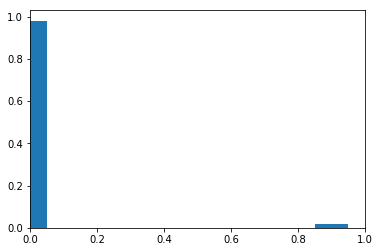

In [13]:
y = df_train.A91B
print('Percentage of 1s is ', y.mean())
print('Percentage of 0s is ', 1-y.mean())
print(y.value_counts())
hist, bin_edges = np.histogram(y)
freq=hist/y.size

plt.bar(bin_edges[:-1], freq, width = .1)
plt.xlim(min(bin_edges), max(bin_edges))
print('As you can see the data is extremely inbalanced')

top 10 explained variance:  [0.09584027 0.08452763 0.05184488 0.04871556 0.03646018 0.01696574
 0.01548118 0.00906699 0.00633602 0.00195536]


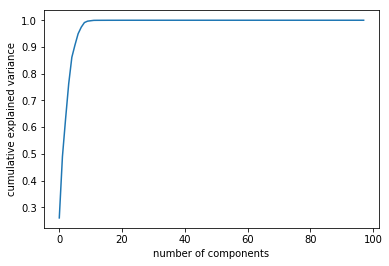

In [14]:
#Visualiziting the input using PCA
pca = PCA()

pca.fit(X_norm)

explained_var = pca.explained_variance_
print('top 10 explained variance: ', explained_var[:10])

#pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

components = pca.components_[:20,:]

(2572, 20)


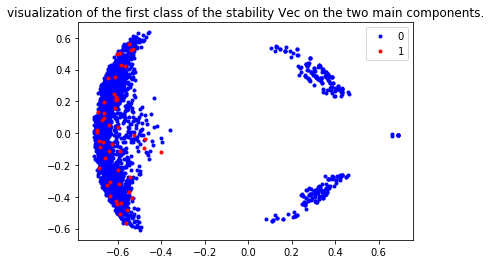

In [15]:
new_data = np.dot(X_norm, components.T)
print(new_data.shape)
indexes_0 = y==0.0
indexes_1 = y==1.0
plt.plot(new_data[indexes_0,0], new_data[indexes_0,1], 'b.', linestyle='', label='0')
plt.plot(new_data[indexes_1,0], new_data[indexes_1,1], 'r.', linestyle='', label='1')
plt.title('visualization of the first class of the stability Vec on the two main components.')
plt.legend()
#plt.show()

## Logistic Regression

In [16]:
X_train, X_test, y_train, y_test = train_test_split(new_data, y,
                                                    test_size=0.33,
                                                    shuffle=True,
                                                    random_state=42)

In [17]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression

# instantiate model
logreg = LogisticRegression()

# fit model
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
#Make prediction using fitted model
y_pred = logreg.predict(X_test)

### Assesing Model performance

In [19]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics


In [20]:
precision = precision_score(y_test.values, y_pred, average='micro')
recall = recall_score(y_test.values, y_pred, average='micro')
F1 = f1_score(y_test.values, y_pred, average='micro')

accuracy = np.mean((y_test.values == y_pred))

print('precision: ', precision, '  recall: ', recall, '  F1: ', F1, '  accuracy: ', accuracy)

precision:  0.983510011778563   recall:  0.983510011778563   F1:  0.983510011778563   accuracy:  0.983510011778563


In [21]:
# examine the class distribution of the testing set
print('Percentage of 1s is ', y_test.mean())
print('Percentage of 0s is ', 1-y_test.mean())
print(y_test.value_counts())

Percentage of 1s is  0.016489988221436984
Percentage of 0s is  0.983510011778563
0    835
1     14
Name: A91B, dtype: int64


In [22]:
#Comparing against a null predictor
max(y_test.mean(), 1 - y_test.mean())

0.983510011778563

In [23]:
# print the first 25 true and predicted responses
print('True:', y_test.values[0:25])
print('False:', y_pred[0:25])

True: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
False: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [24]:
#Confusion Metric
confusion = metrics.confusion_matrix(y_test, y_pred)
print(confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print('accuracy score',(TP + TN) / float(TP + TN + FP + FN))
#print(metrics.accuracy_score(y_test, y_pred))

classification_error = (FP + FN) / float(TP + TN + FP + FN)

print('classification error', classification_error)
#print(1 - metrics.accuracy_score(y_test, y_pred_class))

sensitivity = TP / float(FN + TP)

print('sensitivity',sensitivity)
print(metrics.recall_score(y_test, y_pred))

specificity = TN / (TN + FP)

print('specificity',specificity)

false_positive_rate = FP / float(TN + FP)

print('false positive rate',false_positive_rate)
#print(1 - specificity)

precision = TP / float(TP + FP)

print('precision',precision)
print(metrics.precision_score(y_test, y_pred))

[[835   0]
 [ 14   0]]
accuracy score 0.983510011778563
classification error 0.016489988221436984
sensitivity 0.0
0.0
specificity 1.0
false positive rate 0.0
precision nan
0.0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model is not performing as expected since it barely outperforms a null predictor.

Therefore lets analyze it carefully

In [25]:
print('Predicted:', logreg.predict(X_test)[0:11]) #first 10 predicted responses
print('True:     ', y_test.values[0:11]) 

Predicted: [0 0 0 0 0 0 0 0 0 0 0]
True:      [0 0 0 0 0 0 0 0 0 0 1]


In [26]:
y_pred_prob=logreg.predict_proba(X_test)[:,1] #first 10 predicted probabilities
#print(y_pred_prob)

Text(0,0.5,'Frequency')

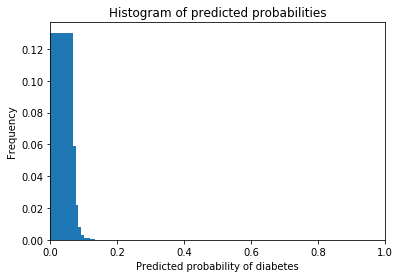

In [27]:
# histogram of predicted probabilities
hist, bin_edges = np.histogram(y_pred_prob)
freq=hist/y.size

plt.bar(bin_edges[:-1], freq, width = .1)
plt.xlim(min(bin_edges), max(bin_edges))

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')

In [28]:
from sklearn.preprocessing import binarize


In [29]:
y_pred_class = binarize(y_pred_prob.reshape(1,-1), 0.035)[0]

In [30]:
# new confusion matrix (threshold of 0.035)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[761  74]
 [ 10   4]]


## Revise the inputs to the Model

In [31]:
print(y.value_counts())
#print(y.iloc[y.nonzero()[0]])

0    2522
1      50
Name: A91B, dtype: int64


In [32]:
# These are the only compunds that have stable elements for A91B
stable_comp=df_train.loc[y==1,['formulaA','formulaB']]

In [33]:
stable_comp_num=stable_comp.values

In [34]:
stable_A=np.unique(stable_comp_num[:,0])
stable_B=np.unique(stable_comp_num[:,1])

In [35]:
stable_A.shape

(34,)

In [36]:
df_train.shape

(2572, 109)

In [37]:
df_unique= pd.DataFrame()
print(df_unique.shape)
for cnt in range(stable_A.shape[0]):
    #print(stable_A[cnt])
    df_tmp=df_train.loc[df_train['formulaA']==stable_A[cnt]]
    df_unique=pd.concat([df_unique, df_tmp],axis=0)
    #print(df_tmp.shape)
    #print(df_unique.shape)
    
print(df_unique.shape)

for cnt in range(stable_B.shape[0]):
    #print(stable_A[cnt])
    df_tmp=df_train.loc[df_train['formulaB']==stable_B[cnt]]
    df_unique=pd.concat([df_unique, df_tmp],axis=0)
    #print(df_tmp.shape)
    #print(df_unique.shape)
    
print(df_unique.shape)

(0, 0)
(1059, 109)
(1615, 109)


In [38]:
y_unique= pd.DataFrame()
print(y_unique.shape)
for cnt in range(stable_A.shape[0]):
    #print(stable_A[cnt])
    df_tmp=y.loc[df_train['formulaA']==stable_A[cnt]]
    y_unique=pd.concat([y_unique, df_tmp],axis=0)
    #print(df_tmp.shape)
    #print(df_unique.shape)
    
print(y_unique.shape)

for cnt in range(stable_B.shape[0]):
    #print(stable_A[cnt])
    df_tmp=y.loc[df_train['formulaB']==stable_B[cnt]]
    y_unique=pd.concat([y_unique, df_tmp],axis=0)
    #print(df_tmp.shape)
    #print(df_unique.shape)
    
print(y_unique.shape)

(0, 0)
(1059, 1)
(1615, 1)


In [39]:
X = df_unique[feature_cols]
print(X.shape)

(1615, 98)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y_unique,
                                                    test_size=0.33,
                                                    shuffle=True,
                                                    random_state=42)

In [41]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression

# instantiate model
logreg = LogisticRegression()

# fit model
logreg.fit(X_train, y_train)

#Make prediction using fitted model
y_pred = logreg.predict(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [43]:
# examine the class distribution of the testing set
print('Percentage of 1s is ', y_test.mean())
print('Percentage of 0s is ', 1-y_test.mean())
print(y_test.value_counts())

Percentage of 1s is  0    0.067542
dtype: float64
Percentage of 0s is  0    0.932458
dtype: float64


AttributeError: 'DataFrame' object has no attribute 'value_counts'

In [44]:
#Confusion Metric
confusion = metrics.confusion_matrix(y_test, y_pred)
print(confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print('accuracy score',(TP + TN) / float(TP + TN + FP + FN))
#print(metrics.accuracy_score(y_test, y_pred))

classification_error = (FP + FN) / float(TP + TN + FP + FN)

print('classification error', classification_error)
#print(1 - metrics.accuracy_score(y_test, y_pred_class))

sensitivity = TP / float(FN + TP)

print('sensitivity',sensitivity)
print(metrics.recall_score(y_test, y_pred))

specificity = TN / (TN + FP)

print('specificity',specificity)

false_positive_rate = FP / float(TN + FP)

print('false positive rate',false_positive_rate)
#print(1 - specificity)

precision = TP / float(TP + FP)

print('precision',precision)
print(metrics.precision_score(y_test, y_pred))

[[490   7]
 [ 27   9]]
accuracy score 0.9362101313320825
classification error 0.06378986866791744
sensitivity 0.25
0.25
specificity 0.9859154929577465
false positive rate 0.014084507042253521
precision 0.5625
0.5625
